## GAN(?)+Autoencoder Idea

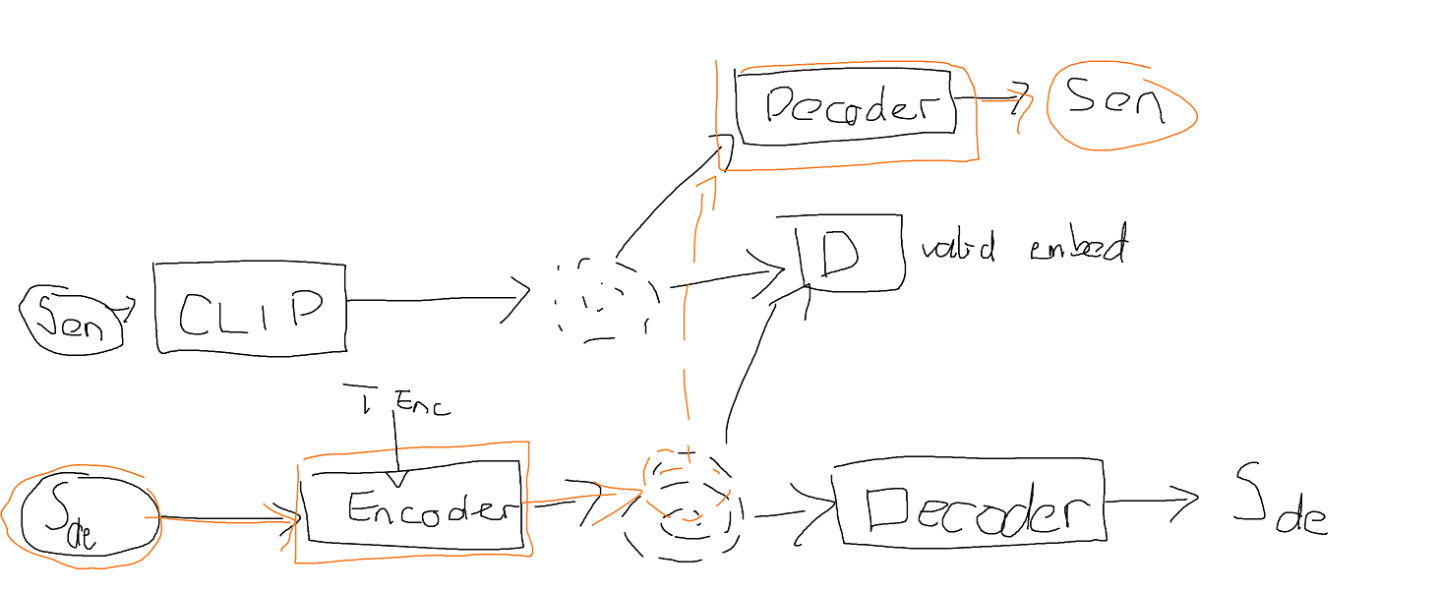


# Define Models
We will create 4 models:

1. Monolingual generator (expert at i.e. FR, DE) - transformer encoder+decoder
2. CLIP Embedding Decoder - transformer decoders
3. Discriminator - linear neural network (subject to change)
4. Translator - two linear parts from embedding space to embedding space (thought of as a transform function from FR -> EN, and the inverse EN -> FR)

We refer to 2 agents that are learning to understand their respective languages, both represented by transformers. Base expert is the agent that 'understands' English (from CLIP). Other expert is agent that is an expert of the other language.

In [ ]:
from torch import nn
from torch import Tensor
import math

# https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
  def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x: Tensor) -> Tensor:
    """
    Args:
        x: Tensor, shape [seq_len, batch_size, embedding_dim]
    """
    x = x + self.pe[:x.size(0)]
    return self.dropout(x)

# https://jamesmccaffrey.wordpress.com/2022/09/09/simplest-transformer-seq-to-seq-example/
class Transformer(nn.Module): # same language/monolingual
  def __init__(self, ntoken: int, d_model: int = 512, nhead: int = 4, d_hid: int = 512,
               nlayers: int = 4, dropout: float = 0.5):
    super().__init__()

    self.model_type = 'Transformer'

    self.embed = nn.Embedding(ntoken, d_model)

    self.pos_enc = PositionalEncoding(d_model, dropout)
    encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout,
                                                batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layers, nlayers)

    decoder_layers = nn.TransformerDecoderLayer(d_model, nhead, d_hid, dropout,
                                                batch_first=True)
    self.decoder = nn.TransformerDecoder(decoder_layers, nlayers)

    self.d_model = d_model

    self.dense = nn.Linear(d_model, ntoken)

    self.init_weights()

  def init_weights(self) -> None:
    initrange = 0.1
    self.dense.weight.data.uniform_(-initrange, initrange)
    self.dense.bias.data.zero_()

  def forward(self, src, tgt, tgt_mask, tp_mask=None, sp_mask=None):
    s = self.embed(src)
    t = self.embed(tgt)

    s = self.pos_enc(s)
    t = self.pos_enc(t)

    e = self.encoder(s, src_key_padding_mask=sp_mask)
    d = self.decoder(t, e, tgt_mask=tgt_mask, tgt_key_padding_mask=tp_mask, memory_key_padding_mask=sp_mask)
    z = self.dense(d)
    # z = nn.functional.softmax(z, dim=2)
    return z, e

  def encode(self, src, sp_mask=None):
    s = self.embed(src)
    s = self.pos_enc(s)
    e = self.encoder(s, src_key_padding_mask=sp_mask)
    return e

class Translator(nn.Module):
  def __init__(self, i_embed_size = 512, o_embed_size = 512, nlayers = 1, hidden = 1024):
    super().__init__()
    
    # based off https://arxiv.org/abs/1809.03633
    self.G = nn.Sequential(nn.Linear(i_embed_size, hidden))
    self.F = nn.Sequential(nn.Linear(o_embed_size, hidden))
    for i in range(nlayers-1):
      self.G.append(nn.Linear(hidden, hidden))
      self.F.append(nn.Linear(hidden, hidden))
    self.G.append(nn.Linear(hidden, o_embed_size))
    self.F.append(nn.Linear(hidden, i_embed_size))

  def forward(self, i_emb):
    o = self.G(i_emb)
    i = self.F(o)
    return o, i
  
class Decoder(nn.Module):
  def __init__(self, ntoken: int, d_model: int = 512, nhead: int = 4, d_hid: int = 512,
               dropout: float = 0.5, nlayers: int = 4):
    super().__init__()
    self.embed = nn.Embedding(ntoken, d_model)
    self.pos_enc = PositionalEncoding(d_model, dropout)

    decoder_layers = nn.TransformerDecoderLayer(d_model, nhead, d_hid, dropout,
                                                batch_first=True)
    self.decoder = nn.TransformerDecoder(decoder_layers, nlayers)
    self.dense = nn.Linear(d_model, ntoken)
  
  def forward(self, enc, tgt, tgt_mask):
    t = self.embed(tgt)
    t = self.pos_enc(t)

    d = self.decoder(t, enc, tgt_mask=tgt_mask)
    z = self.dense(d)
    return z
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(512, 100),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(100, 1),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.model(x)
        return out.view(x.size(0))